# 참고

https://pizzathief.oopy.io/dbscan

https://github.com/wikibook/pymlrev2/blob/main/7%EC%9E%A5/7-5_DBSCAN.ipynb

# DBSCAN(Density Based Spatial Clustering of Applications with Noise)

밀도 기반 군집화 알고리즘. 

* 데이터 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화 가능 예를들어 내부 원모양과 외부 원모양 형태 분포를 가진 데이터 분포를 가진 데이터 군집화시 k평균, GMM 평균이동으로는 효과적인 군집화가 어려울 수 있다. 

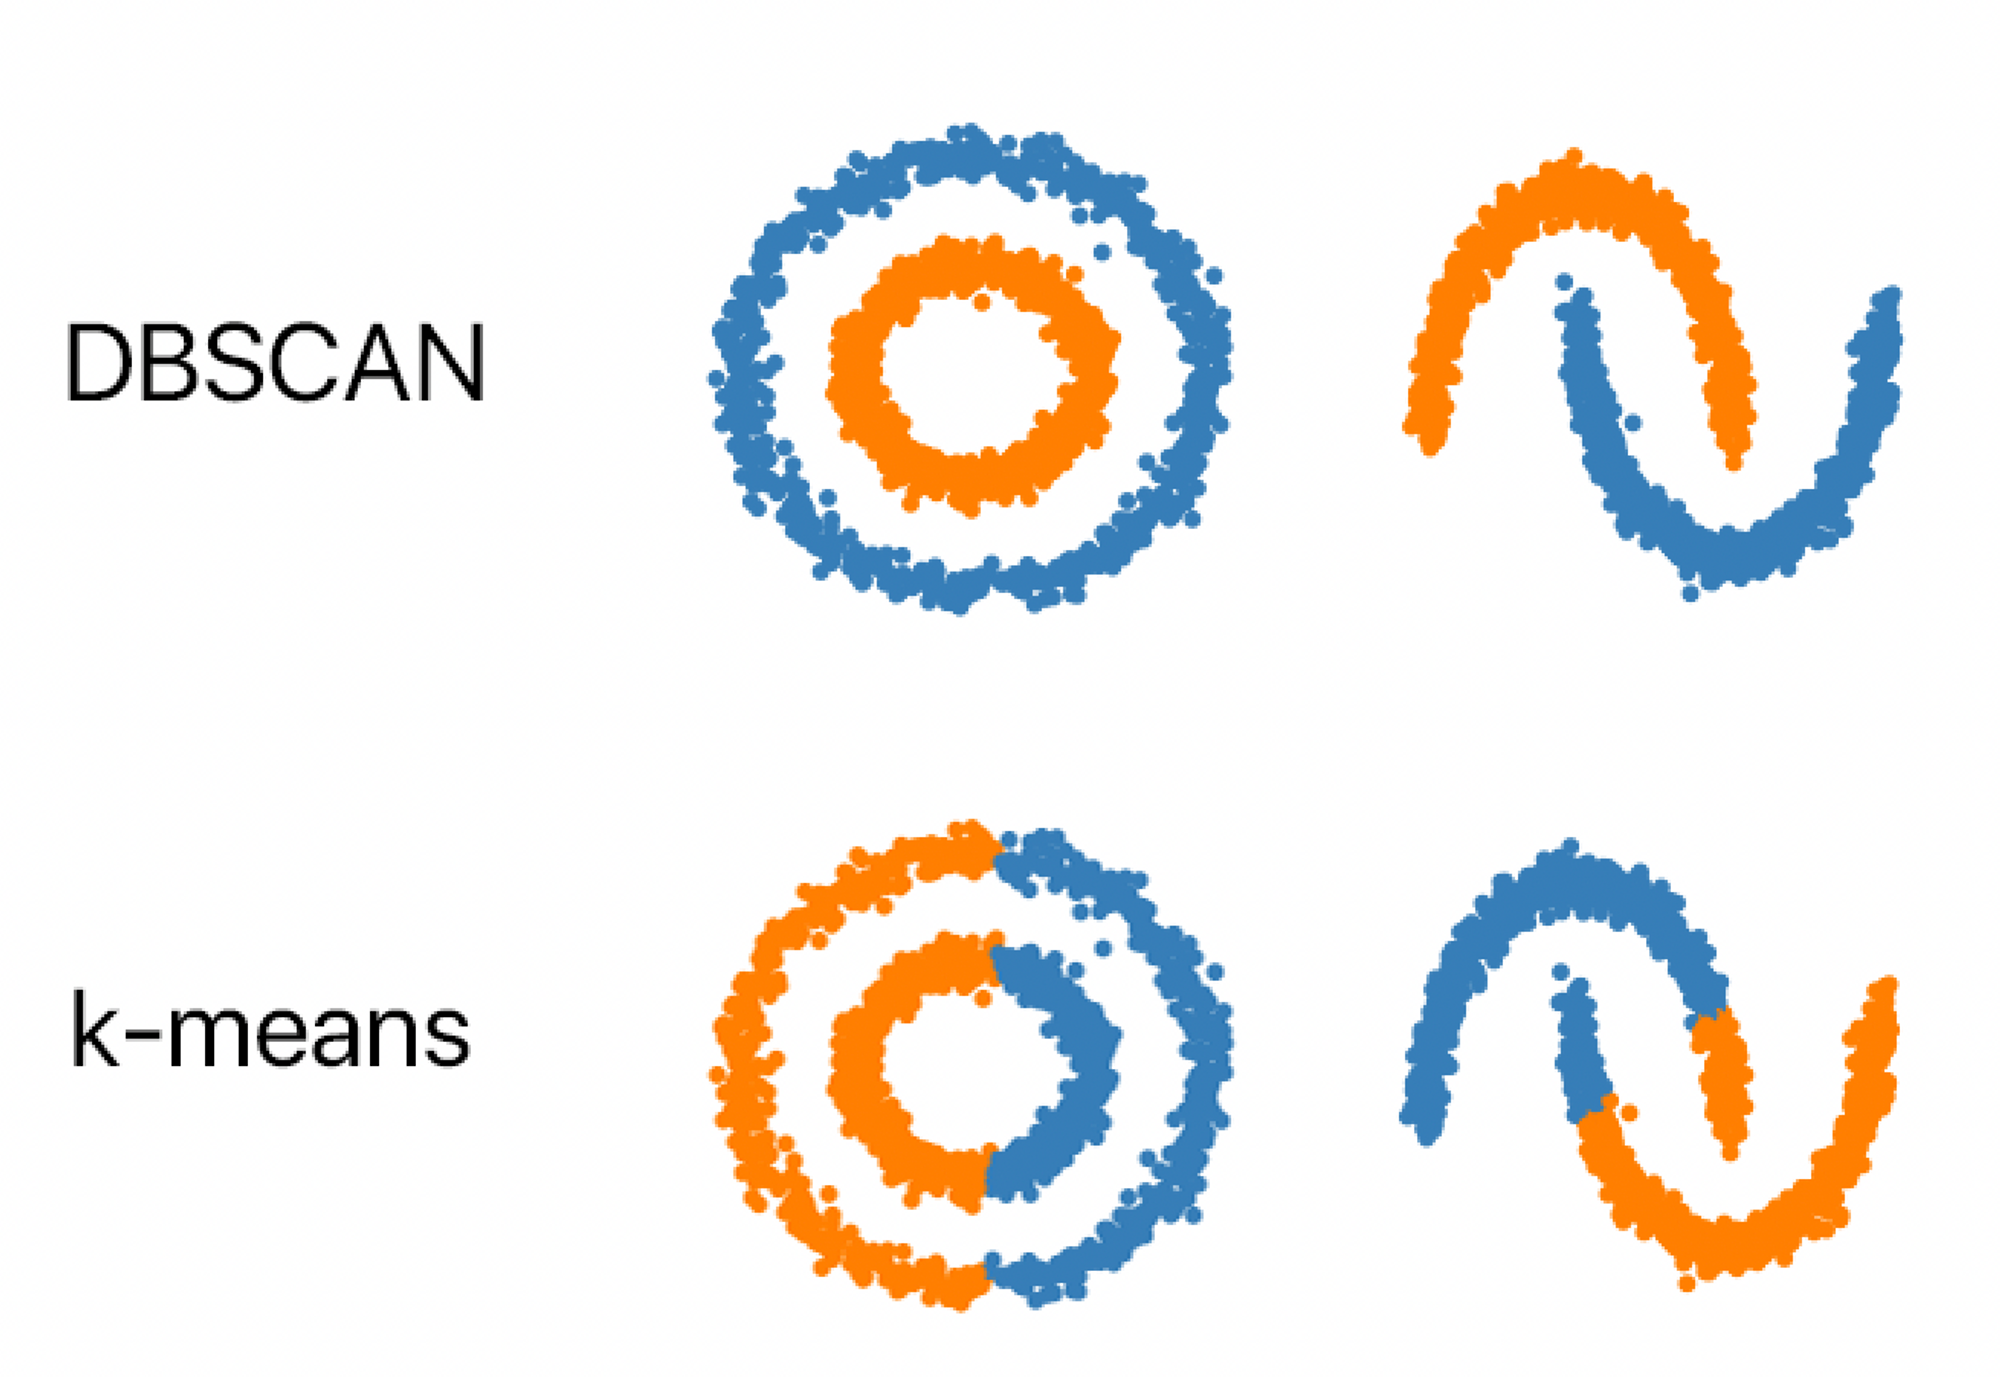

## DBSCAN의 중요 파라미터

* `입실론주변 영역(epsilon)`: 개별 데이터를 중심으로 입실론 반경을 가지는 원형 영역.
* `최소 데이터 개수(min point)`: 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수.


입실론 주변 영역 내 포함되는 최소 데이터 개수를 충족시키는가에 따라 데이터 포인트(각 샘플)를 다음과 같이 정의함

* `핵심 포인트(Core point)` : 입실론 반경 내 최소 데이터 개수 이상의 타 데이터가 있을경우

* `이웃 포인트`: 주변영역내 위치한 타 데이터 포인트
* `경계 포인트(Border point)`: 주변 영역 내 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만, 핵심 포인트를 이웃 포인트로 가지고 있는 데이터
* `잡음 포인트(Noise point)`: 주변 영역 내 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않고, 이웃포인트로 핵심 포인트도 없는 데이터


## 군집화 방법

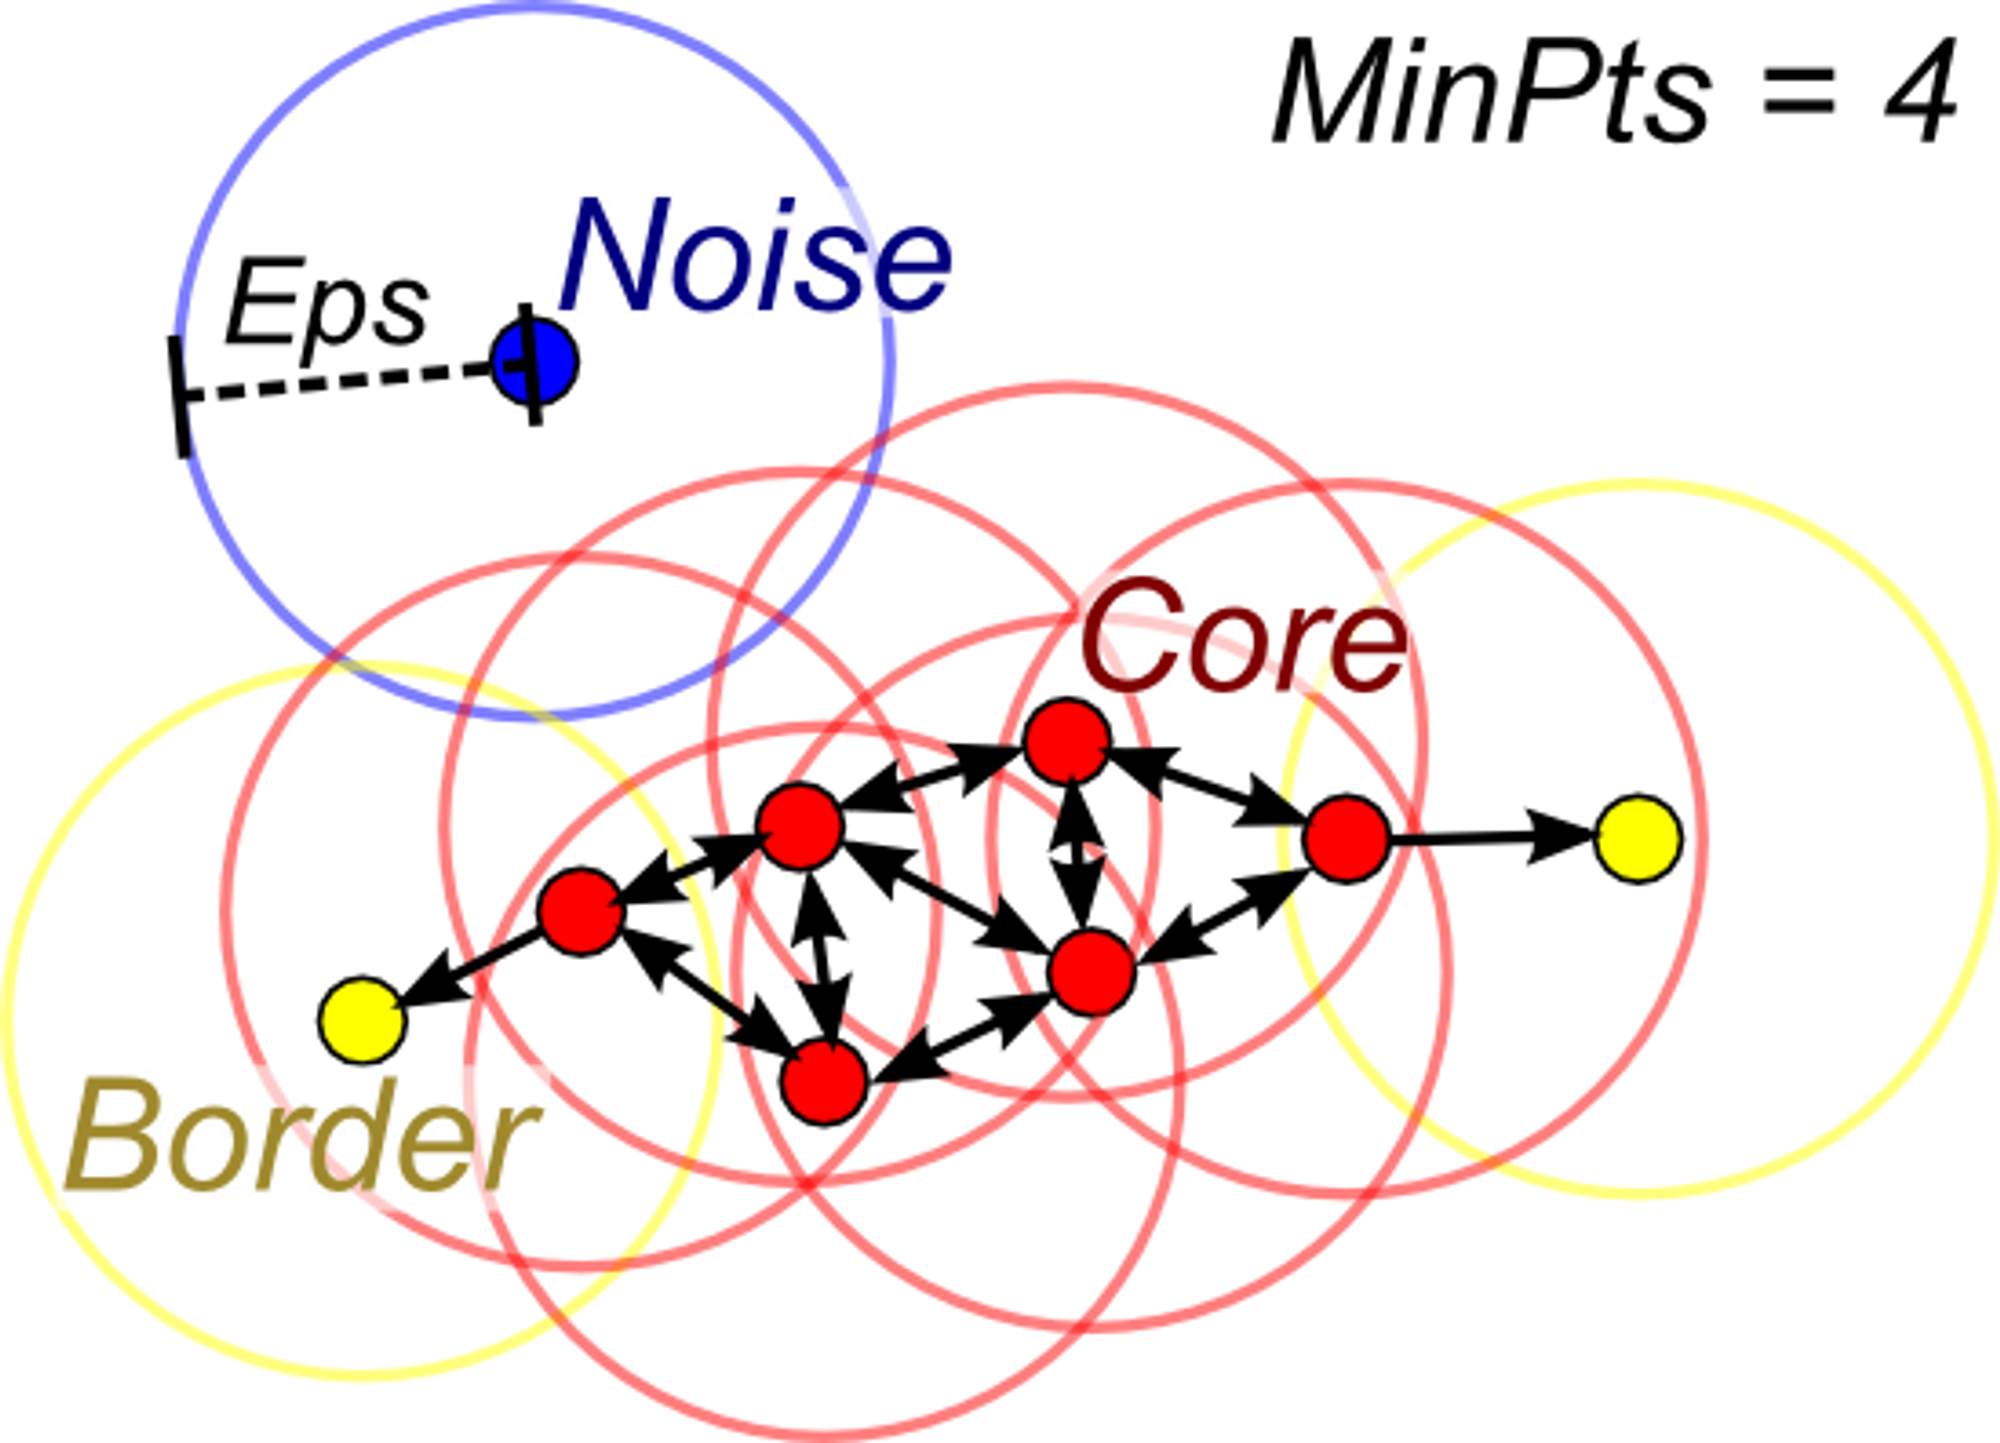

DBSCAN은 입실론 주변 영역의 최소 데이터 개수를 포함하는 밀도 기준을 충족시키는 데이터인 핵심포인터를 연결하면서 군집화를 구성한다.

# 붓꽃 데이터를 이용해 DBSCAN 적용

In [2]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [3]:
from sklearn.cluster import DBSCAN

# 입실론 반경 0.6
# 최소 데이터 개수 8개 설정

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64


-1 레이블은 노이즈에 속하는 군집을 의미. 따라서 다음의 데이터는 0과 1 두개의 군집으로 군집화되었다. DBSCAN은 군집 개수를 자동으로 지정하며 실제 데이터의 타겟값 레이블(3개)와 다르다고하여(2개로 군집화됨) 효율이 떨어진다는 의미가 아님.


# 시각화하기

2차 평면에 표현하기 위해 PCA를 이용해 2개 피처로 압축 변환하여 시각화

In [4]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

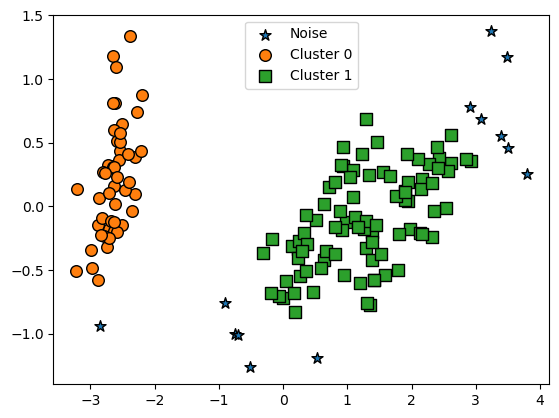

In [5]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

DBSCAN은 입실론값과 최소 데이터 개수 파라미터를 통해 최적 군집을 찾는 게 중요하다.

입실론값이 증가하면 반경이 커져 포함 데이터 개수도 증가하고 노이즈가 작아지는 것이 알반적
## eps = 0.8로 증가시켜 군집화 수행

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: dbscan_cluster, dtype: int64


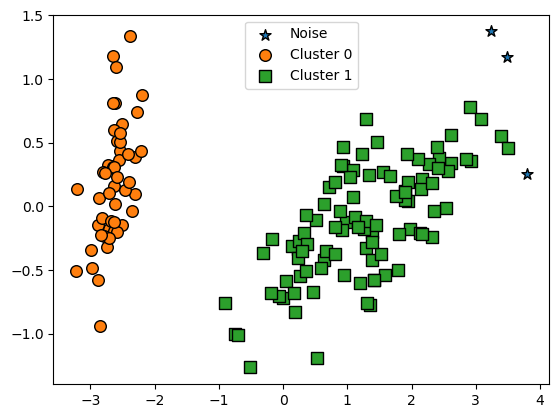

In [6]:
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

## eps = 0.6 유지하고 최소데이터 개수를 늘렸을 때

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: dbscan_cluster, dtype: int64


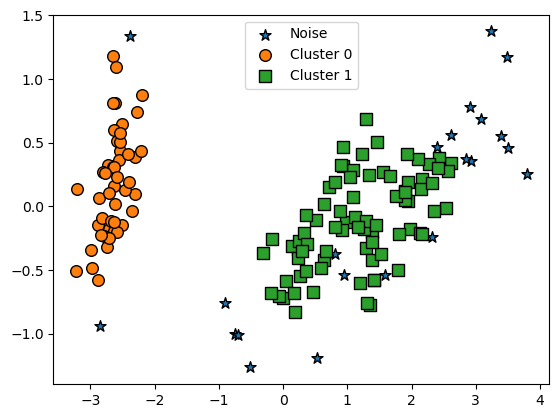

In [7]:

dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

기존보다 노이즈값이 증가한 것을 확인할 수 있다.

# DBSCAN 적용하기 – make_circles() 데이터 세트 

기하학적 분포를 가진 데이터 세트에서 DBSCAN과 타 알고리즘 비교

## make_circles()를 통해 내부 원과 외부 원 형태로 된 2차원 데이터 세트 생성

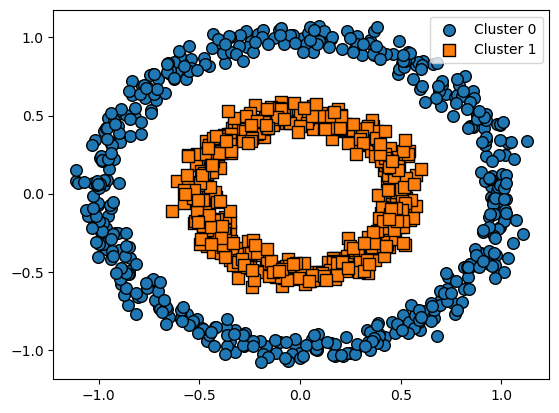

In [9]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

## K 평균을 사용해 군집화 수행

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


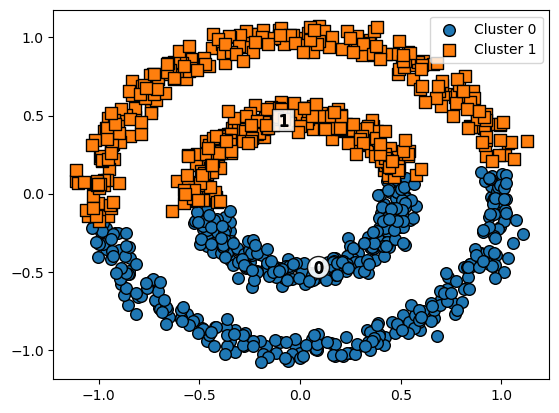

In [10]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

1과 0으로 표시된 군집 중심을 기반으로 군집화되었다. k평균은 데이터의 거리 기반 군집화이기에 다음과 같은 결과가 나왔다. 

## GMM을 사용하여 군집화 수행

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


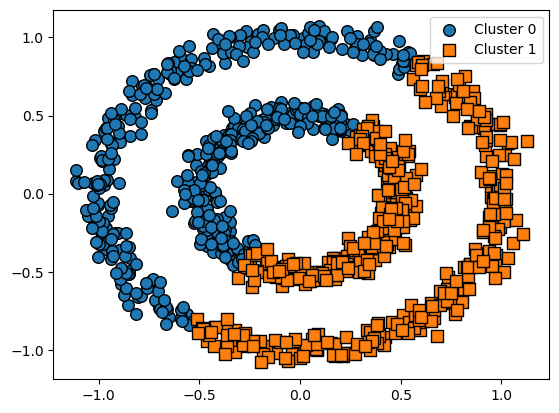

In [11]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

GMM도 일렬로 늘어선 데이터에서 효과적으로 적용 가능했으나, 내부와 외부의 원형으로 이ㅝ진 복잡한 형태의 데이터에서는 군집화가 원활히 이뤄지지 않는다.

## DBSCAN기반 군집화 수행

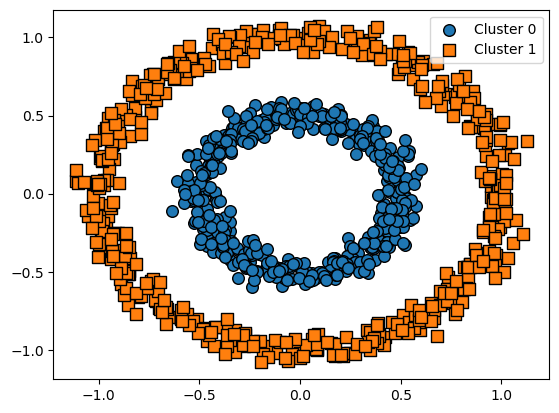

In [13]:
 # DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)